In [1]:
from influxdb.commands import InfluxDBQueries
import warnings
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

ImportError: cannot import name 'CAPMAnalysis' from partially initialized module 'influxdb.commands' (most likely due to a circular import) (/Users/gaszneradam/Documents/BME/6_felev/onlab/befektetesi_portfolio_elemzes/influxdb/commands/__init__.py)

In [2]:
df_train = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2022-01-01T01:00:00Z", stop="2023-01-01T01:00:00Z")

In [3]:
df_train

,low,close,volume,open,high
time,,,,,
2022-01-01 01:05:00+00:00,46574.06,46582.68,78.29231,46656.14,46661.64
2022-01-01 01:10:00+00:00,46579.90,46675.00,74.96125,46582.67,46678.13
2022-01-01 01:15:00+00:00,46674.99,46766.99,65.66259,46675.00,46767.24
2022-01-01 01:20:00+00:00,46752.17,46876.81,83.41304,46766.99,46900.00
2022-01-01 01:25:00+00:00,46799.00,46846.03,54.86916,46876.82,46949.99
...,...,...,...,...,...
2023-01-01 00:40:00+00:00,16508.39,16524.04,350.25779,16527.27,16530.09
2023-01-01 00:45:00+00:00,16512.70,16515.43,176.75702,16524.83,16525.25
2023-01-01 00:50:00+00:00,16515.43,16529.16,179.03511,16515.91,16535.66


In [4]:
df_train['target'] = df_train['close'].shift(-12) - df_train['close']

<Axes: >

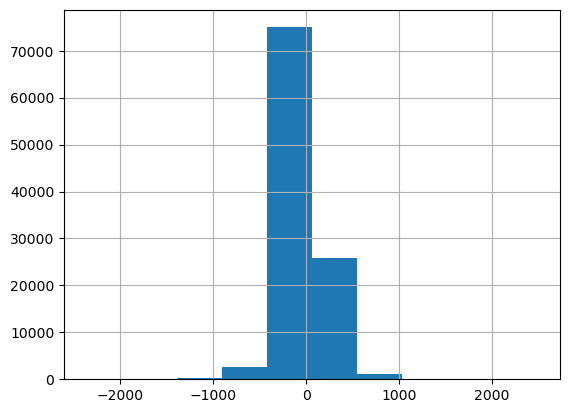

In [5]:
df_train['target'].hist()

In [6]:
df_train['ema_50'] = df_train['close'].ewm(span=50).mean()
df_train['ema_125'] = df_train['close'].ewm(span=125).mean()
df_train['ema_250'] = df_train['close'].ewm(span=250).mean()

In [7]:
df_train['volatility_24h'] = df_train['close'].rolling(window=288).std()

In [8]:
import ta

In [9]:
macd = ta.trend.MACD(close=df_train['close'])
df_train['macd'] = macd.macd()
df_train['macd_signal'] = macd.macd_signal()
df_train['macd_diff'] = macd.macd_diff()

In [10]:
df_train['momentum_6h'] = df_train['close'] - df_train['close'].shift(72)

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)

In [13]:
input_vals = ['ema_50' , 'ema_125', 'ema_250', 'volatility_24h', 'macd', 'macd_signal', 'macd_diff', 'momentum_6h']

In [14]:
df_train = df_train.dropna()

In [15]:
rf.fit(df_train[input_vals], df_train['target'])

RandomForestRegressor(n_estimators=500, random_state=42)

In [16]:
df_test = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2023-01-01T01:00:00Z", stop="2023-03-01T01:00:00Z")

In [17]:
df_test

,high,low,close,volume,open
time,,,,,
2023-01-01 01:05:00+00:00,16537.66,16525.78,16531.02,243.11353,16529.59
2023-01-01 01:10:00+00:00,16540.47,16530.31,16539.20,152.21301,16530.39
2023-01-01 01:15:00+00:00,16541.80,16535.40,16538.21,159.35521,16539.20
2023-01-01 01:20:00+00:00,16540.82,16534.00,16538.59,87.71309,16537.68
2023-01-01 01:25:00+00:00,16539.95,16530.76,16536.22,160.88183,16539.04
...,...,...,...,...,...
2023-03-01 00:40:00+00:00,23207.10,23178.28,23186.96,406.02806,23199.21
2023-03-01 00:45:00+00:00,23194.86,23140.50,23145.49,505.40035,23186.96
2023-03-01 00:50:00+00:00,23149.35,23088.00,23091.08,695.57913,23146.08


In [18]:
df_test['target'] = df_test['close'].shift(-12) - df_test['close']

In [19]:
df_test['ema_50'] = df_test['close'].ewm(span=50).mean()
df_test['ema_125'] = df_test['close'].ewm(span=125).mean()
df_test['ema_250'] = df_test['close'].ewm(span=250).mean()
df_test['volatility_24h'] = df_test['close'].rolling(window=288).std()
macd = ta.trend.MACD(close=df_test['close'])
df_test['macd'] = macd.macd()
df_test['macd_signal'] = macd.macd_signal()
df_test['macd_diff'] = macd.macd_diff()
df_test['momentum_6h'] = df_test['close'] - df_test['close'].shift(72)

In [20]:
df_test = df_test.dropna()

In [21]:
df_test['pred'] = rf.predict(df_test[input_vals])

In [22]:
from sklearn.metrics import root_mean_squared_error

In [23]:
root_mean_squared_error(df_test['target'], df_test['pred'])

127.1360186948066

In [24]:
df_test['pred_direction'] = df_test['pred'].apply(lambda x: 1 if x > 0 else -1)
df_test['target_direction'] = df_test['target'].apply(lambda x: 1 if x > 0 else -1)

In [25]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(df_test['target_direction'], df_test['pred_direction']))

              precision    recall  f1-score   support

          -1       0.50      0.43      0.46      8021
           1       0.53      0.60      0.56      8672

    accuracy                           0.52     16693
   macro avg       0.51      0.51      0.51     16693
weighted avg       0.52      0.52      0.51     16693



In [27]:
df_test['pred_value'] = df_test['pred'].shift(12) + df_test['close'].shift(12)

In [28]:
df_test['pred_value'].dropna(inplace=True)

In [29]:
import matplotlib.pyplot as plt

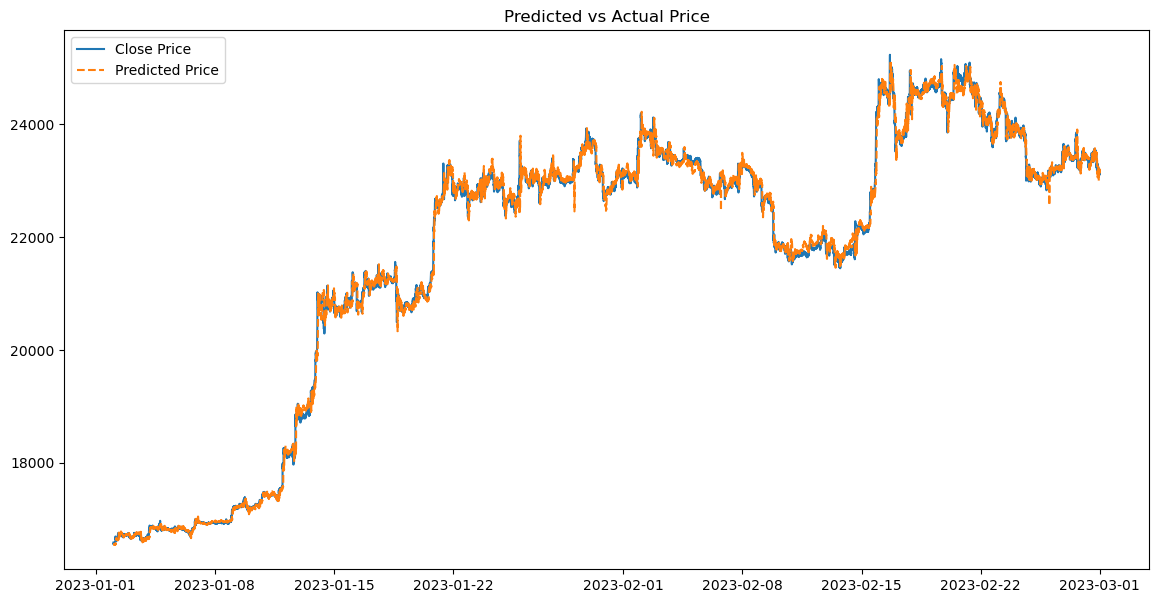

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(df_test['close'], label='Close Price')
plt.plot(df_test['pred_value'], label='Predicted Price', linestyle='--')
plt.title('Predicted vs Actual Price')
plt.legend()
plt.show()